In [1]:
from examples.tensorflow_examples.models.pix2pix import pix2pix

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from IPython.display import clear_output

tfds.disable_progress_bar()

In [3]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

In [4]:
# dataset["segmentation_mask"]
dataset

{'test': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 'train': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}

In [5]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [6]:
@tf.function                        #@tf.function converts a Python function to its graph representation
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint["image"], (128, 128))
    input_mask = tf.image.resize(datapoint["segmentation_mask"], (128, 128))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
        
    input_image, input_maks = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [7]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint["image"], (128, 128))
    input_mask = tf.image.resize(datapoint["segmentation_mask"], (128, 128))
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [8]:
TRAIN_LENGTH = info.splits["train"].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset["test"].map(load_image_test)

In [10]:
train_sample = next(iter(train))

In [11]:
image_sample, mask_sample = train_sample[0].numpy(), train_sample[1].numpy()

(-0.5, 127.5, 127.5, -0.5)

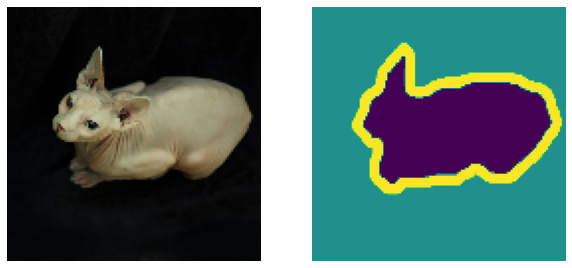

In [12]:
# plt.figure(figsize=(10,10))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.axis("off")
ax1.imshow(image_sample)
ax2.imshow(mask_sample.squeeze())
ax2.axis("off")

In [13]:
test_sample = next(iter(test))

In [14]:
test_image, test_mask = test_sample[0].numpy(), test_sample[1].numpy()

In [15]:
mask_sample.reshape(128, 128)

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)

(-0.5, 127.5, 127.5, -0.5)

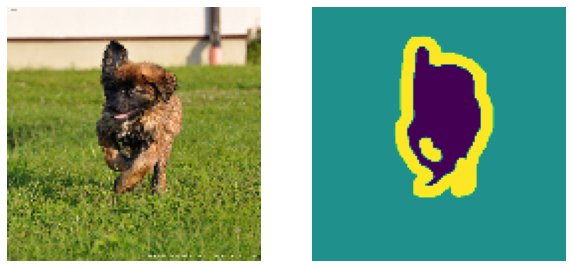

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.axis("off")
ax1.imshow(test_image)
ax2.imshow(test_mask.squeeze())
ax2.axis("off")

In [17]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [18]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    
    title = ["Input Image", "True Mask", "Predicted Mask"]
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

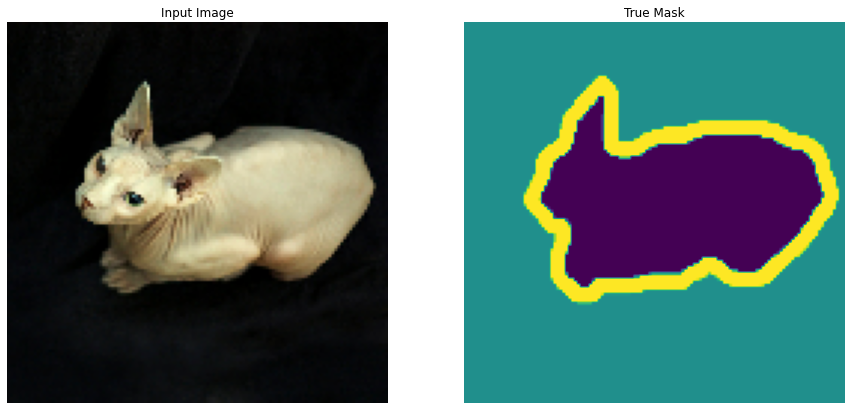

In [19]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [20]:
base_model = keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = [
    "block_1_expand_relu",  #64x64
    "block_3_expand_relu",  #32x32
    "block_6_expand_relu",  #16x16
    "block_13_expand_relu", #8x8
    "block_16_project",     #4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [21]:
layers

[<tf.Tensor 'block_1_expand_relu/Identity:0' shape=(None, 64, 64, 96) dtype=float32>,
 <tf.Tensor 'block_3_expand_relu/Identity:0' shape=(None, 32, 32, 144) dtype=float32>,
 <tf.Tensor 'block_6_expand_relu/Identity:0' shape=(None, 16, 16, 192) dtype=float32>,
 <tf.Tensor 'block_13_expand_relu/Identity:0' shape=(None, 8, 8, 576) dtype=float32>,
 <tf.Tensor 'block_16_project/Identity:0' shape=(None, 4, 4, 320) dtype=float32>]

In [22]:
OUTPUT_CHANNELS = 3

In [23]:
#upsample(filters, size, ....)

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [24]:
def unet_model(output_channels):
    inputs = keras.layers.Input(shape=[128, 128, 3])
    x = inputs
    
    #encode
    skips = down_stack(x)
#     print(type(skips))
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    #decode
    for up, skip in zip(up_stack, skips):
        x = up(x)                             #sequential
        concat = keras.layers.Concatenate()   #concatenation
        x = concat([x, skip])
        
    last = keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding="same")
    
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x)

In [25]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

<class 'list'>


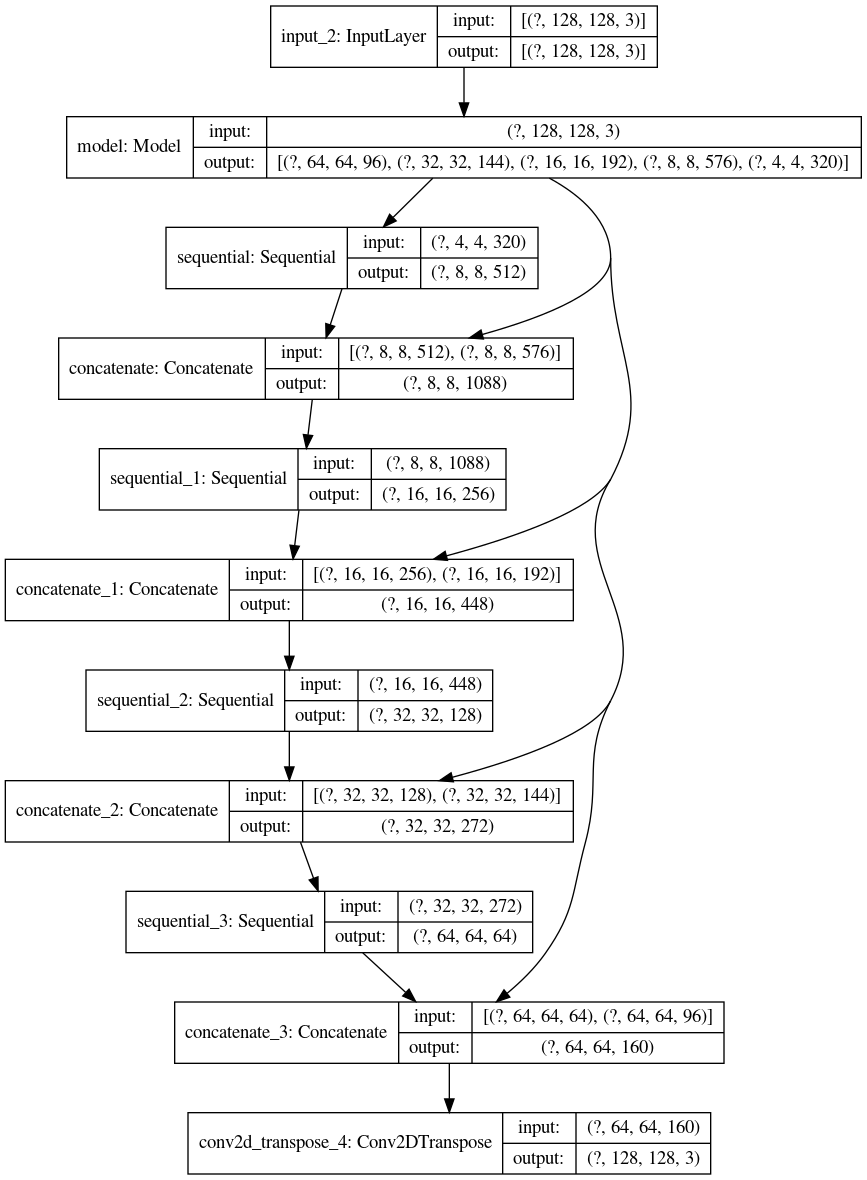

In [26]:
keras.utils.plot_model(model, show_shapes=True)

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[1][3]                

In [28]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [35]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
            
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

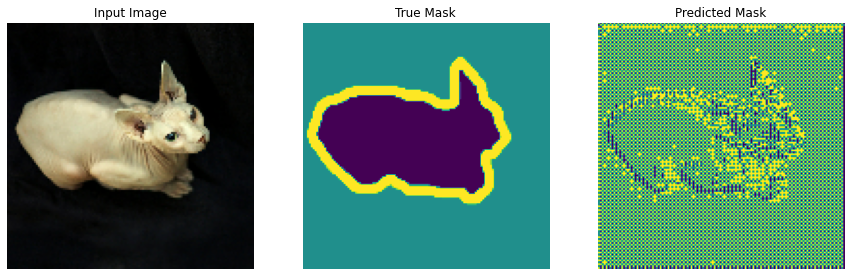

In [36]:
show_predictions()

In [37]:
class DisplayCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [39]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits["test"].num_examples // BATCH_SIZE // VAL_SUBSPLITS

In [ ]:
model_history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_data=test_dataset, callbacks=[DisplayCallback()])

Epoch 1/20
